# 3. Matching the U.S. income distribution by GMM

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import math

### (a)

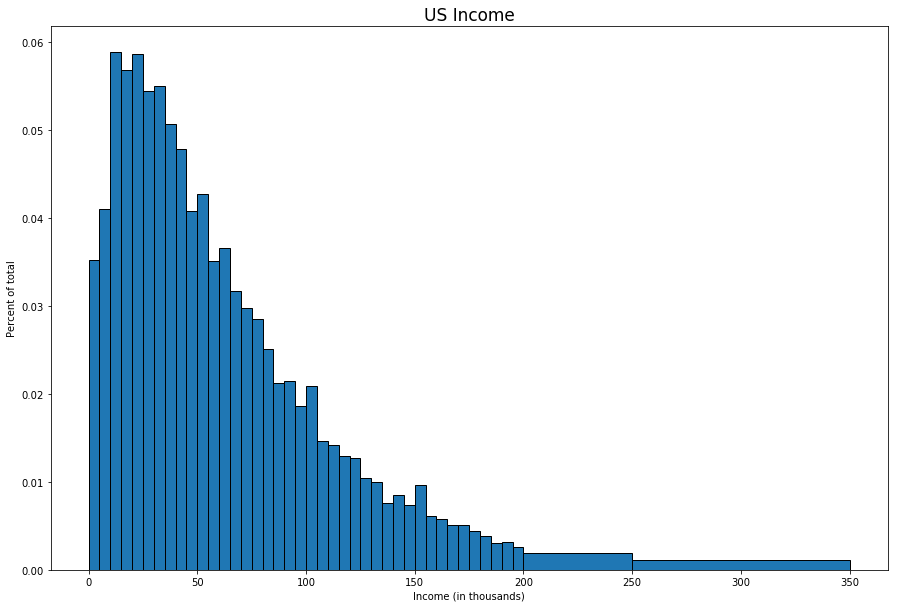

In [38]:
data = np.loadtxt('usincmoms.txt',delimiter='\t')
pcts = data[:,0]
midpts = data[:,1]

bins = np.append(np.linspace(0,200,41),[250, 350])

pcts[-2] = pcts[-2]/10
pcts[-1] = pcts[-1]/20

# scale down midpoints
smidpts = midpts/1000

plt.subplots(figsize=(15, 10))
plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')

plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

### (b)

The lognormal distribution (LN) is the distribution of the exponential of a normally distributed variable with mean $\mu$ and standard deviation $\sigma$. If the variable $x_i$ is lognormally distributed $x_i\sim LN(\mu,\sigma)$, then the log of $x_i$ is normally distributed $\ln(x_i)\sim N(\mu,\sigma)$. The PDF of the lognormal distribution is the following.

$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$

Note that the lognormal distribution has a support that is strictly positive. This is one reason why it is commonly used to approximate income distributions. A household's total income is rarely negative. The lognormal distribution also has a lot of the nice properties of the normal distribution.

Note that in this case, the data moments are neatly presented already - they are the percentages for each bin. Hence we assign:

In [39]:
data_moments = pcts

We have to calculate the model moments given parameters mu and sigma for the lognormal distribution. 
For this purpose, we integrate the lognormal distribution in each bin i, [a_i,b_i].


In [232]:
import scipy.stats as sts

def model_moments(midpts, mu, sigma):
    # small bins have width 5, i.e. 2500 USD to each side
    a_k = midpts - 2500
    a_k[0] = 1e-10
    #a_k[-2] = 200000
    #a_k[-1] = 250000
    
    b_k = midpts + 2500
    #b_k[-2] = 250000
    #b_k[-1] = 350000
    #print(a_k,b_k)
    ple_a_k = sts.norm.cdf(np.log(a_k), mu, sigma ) 
    ple_cdf_b_k = sts.norm.cdf(np.log(b_k), mu, sigma ) 
    modelpcts = ple_cdf_b_k - ple_a_k
    return modelpcts

'''def model_moments(midpts, mu, sigma):
    
    pdf_vals = sts.lognorm.pdf(midpts, s = sigma, scale = np.exp(mu))
    
    return 5000 * pdf_vals'''

def err_vec(mu, sigma, smidpts, pcts, simple = False):
    modelpcts = model_moments(smidpts, mu, sigma)
    
    if simple:
        err_vec1 = modelpcts - pcts
    else:
        err_vec1 = (modelpcts - pcts)/pcts
    #print(err_vec1[:6])
    return err_vec1

def crit(params, *args):
    mu, sigma = params
    smidpts, pcts , W = args
    err = err_vec(mu, sigma, smidpts, pcts)
    crit_val = np.dot(np.dot(err.T, W),err)
    return crit_val



In [233]:
W = np.diag(pcts)
W.shape
#W = np.eye(42)

(42, 42)

In [234]:
import scipy.optimize as opt

mu_init = np.log(pcts @ midpts)
sig_init = np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([mu_init, sig_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(crit, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

      fun: 0.030212613069070342
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.61943245e-06,  -1.83776605e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 5
   status: 0
  success: True
        x: array([ 10.84067115,   1.01697685])
mu_GMM1= 10.840671146  sig_GMM1= 1.01697685089


The PDF of the lognormal distribution is the following.

$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$



In [244]:
mu_init, sig_init

(10.946802869848872, 0.87285783556833663)

In [ ]:
The initial values are fairly close so I will soon plot other initial values.

In [236]:
def LN_pdf(xvals, mu, sigma):
    pdf_vals= (1/(xvals * sigma * np.sqrt(2 * np.pi)) *\
               np.exp(-(np.log(xvals) - mu)**2 /(2 * sigma**2)))
    return pdf_vals

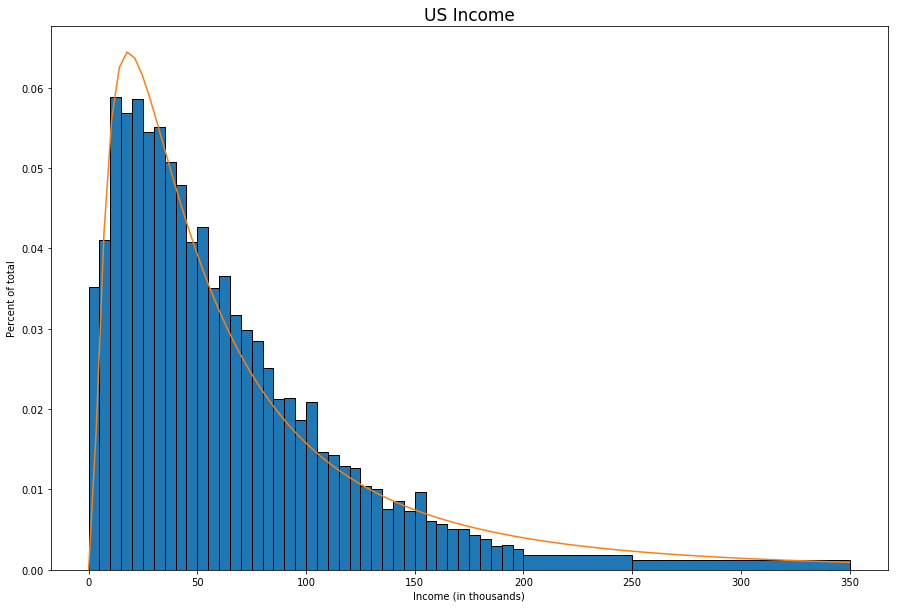

In [248]:
x = np.linspace(0.000001,350000,100)
y = 5000*LN_pdf(x, mu_GMM1, sig_GMM1)

plt.subplots(figsize=(15, 10))

plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')
plt.plot(x/1000,y)
plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

The fit looks good.

In [273]:
import scipy.optimize as opt

mu_init = 1 #np.log(pcts @ midpts)
sig_init = 10 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([mu_init, sig_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(crit, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

      fun: 0.030212613064348928
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.17027524e-07,  -1.00822128e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 171
      nit: 29
   status: 0
  success: True
        x: array([ 10.84067308,   1.01697804])
mu_GMM1= 10.8406730811  sig_GMM1= 1.0169780445


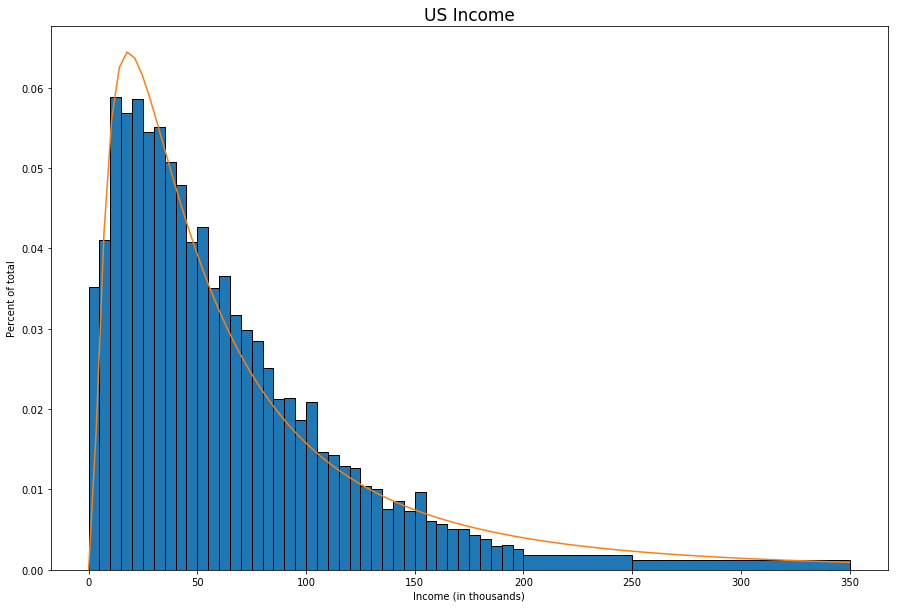

In [274]:
x = np.linspace(0.000001,350000,100)
y = 5000*LN_pdf(x, mu_GMM1, sig_GMM1)

plt.subplots(figsize=(15, 10))

plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')
plt.plot(x/1000,y)
plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

Despite different initial values, the same solution. Let's go more extreme:

In [252]:
import scipy.optimize as opt

mu_init = 0.1 #np.log(pcts @ midpts)
sig_init = 100 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([mu_init, sig_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(crit, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

      fun: 0.91684345408267864
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.20934382e-06,  -1.82076576e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 10
   status: 0
  success: True
        x: array([  55.06197708,  310.4710209 ])
mu_GMM1= 55.0619770776  sig_GMM1= 310.471020903


And it broke - however, that is fairly understandable, since we were far away from what even a naive approach with sample mean etc. would suggest. We judge the first estimation to be a good fit.

### (c)

In [257]:
# Had to retire this function, since it did not seem to be working...
'''def model_momentsGA(midpts, alpha, beta):
    
    # small bins have width 5, i.e. 2500 USD to each side
    a_k = midpts - 2500
    a_k[0] = 1e-10
    #a_k[-2] = 200000
    #a_k[-1] = 250000
    
    b_k = midpts + 2500
    #b_k[-2] = 250000
    #b_k[-1] = 350000
    
    ple_a_k = sts.gamma.cdf(np.log(a_k), alpha, beta)
    ple_cdf_b_k = sts.gamma.cdf(np.log(b_k), alpha, beta)
    modelpcts = ple_cdf_b_k - ple_a_k
    return modelpcts'''


def model_momentsGA(xvals, alpha, beta):
    
    pdf_vals = 1/((beta ** alpha) * math.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    
    return 5000 * pdf_vals

def err_vecGA(alpha, beta, midpts, pcts, simple = False):
    modelpcts = model_momentsGA(midpts, alpha, beta)
    
    if simple:
        err_vec1 = modelpcts - pcts
    else:
        err_vec1 = (modelpcts - pcts)/pcts
    #print(err_vec1[:6])
    return err_vec1

def critGA(params, *args):
    alpha, beta = params
    midpts, pcts , W = args
    err = err_vecGA(alpha, beta, midpts, pcts)
    crit_val = np.dot(np.dot(err.T, W),err)
    return crit_val

In [270]:
import scipy.optimize as opt

alpha_init = 3 #np.log(pcts @ midpts)
beta_init = 20000 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM, beta_GMM = results.x
print('alpha_GMM=', alpha_GMM, ' beta_GMM=', beta_GMM)

      fun: 0.0062921356844260427
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.17981622e-06,   8.67361738e-11])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 108
      nit: 27
   status: 0
  success: True
        x: array([  1.43451001e+00,   4.44240640e+04])
alpha_GMM= 1.4345100085  beta_GMM= 44424.0640153


In [271]:
def pdf_GA(xvals, alpha, beta):
    
    pdf_vals = 1/((beta ** alpha) * math.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    
    return 5000 * pdf_vals

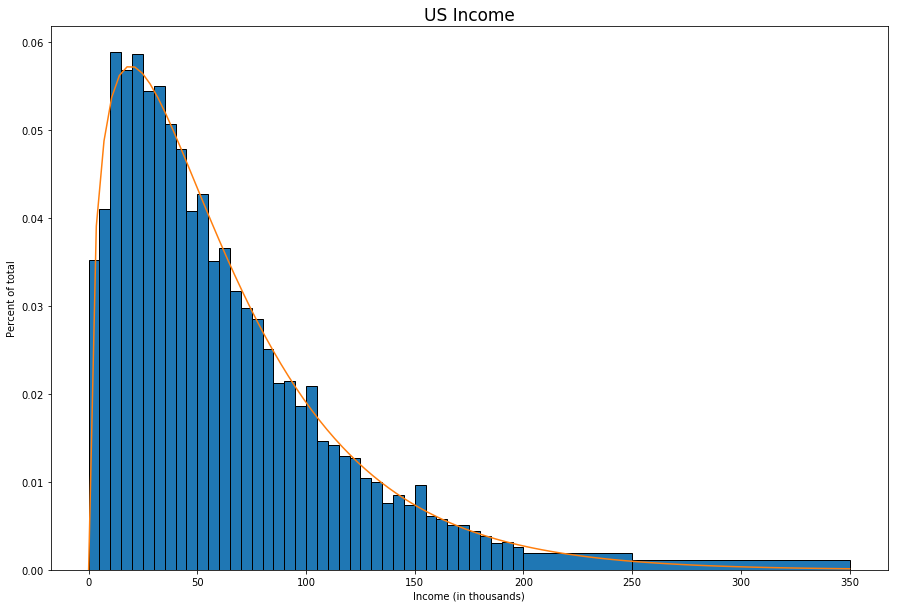

In [272]:
x = np.linspace(0.000001,350000,100)
y = model_momentsGA(x, alpha_GMM, beta_GMM)

plt.subplots(figsize=(15, 10))

plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')
plt.plot(x/1000,y)
plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

Nice-looking fit. Let's try different initial conditions:

In [265]:

alpha_init = 0.1 #np.log(pcts @ midpts)
beta_init = 200000 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

      fun: 0.75216981633497759
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.22044605e-08,  -2.66453526e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 5
   status: 0
  success: True
        x: array([  5.29872143e-02,   2.00000000e+05])
alpha_GMM1= 0.0529872143456  beta_GMM1= 200000.0


In [266]:
alpha_init = 10 #np.log(pcts @ midpts)
beta_init = 2000 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

      fun: 0.5232101444113465
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.44089210e-08,   0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 228
      nit: 39
   status: 0
  success: True
        x: array([  2.94157864e-01,   6.54169479e+06])
alpha_GMM1= 0.294157863788  beta_GMM1= 6541694.79013


In [267]:
alpha_init = 1 #np.log(pcts @ midpts)
beta_init = 500000 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

      fun: 0.31423769753041053
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.22124533e-06,   1.83186799e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 3
   status: 0
  success: True
        x: array([  5.57531903e-01,   5.00000000e+05])
alpha_GMM1= 0.55753190333  beta_GMM1= 500000.0


In [268]:
alpha_init = 1 #np.log(pcts @ midpts)
beta_init = 30000 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

      fun: 0.044297843974067191
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.55111512e-08,  -6.55656085e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([  1.86798801e+00,   3.00000001e+04])
alpha_GMM1= 1.86798801196  beta_GMM1= 30000.0000558


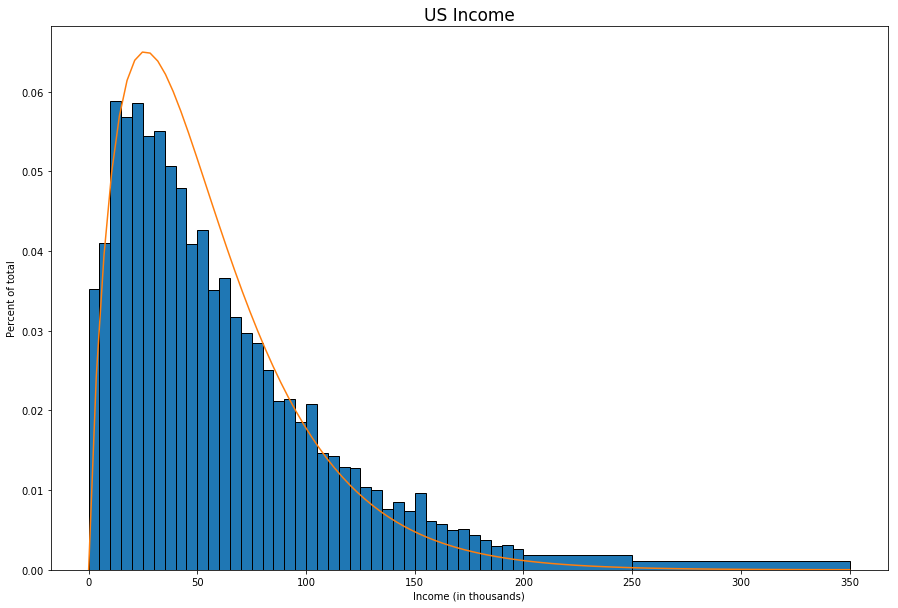

In [269]:
x = np.linspace(0.000001,350000,100)
y = model_momentsGA(x, alpha_GMM1, beta_GMM1)

plt.subplots(figsize=(15, 10))

plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')
plt.plot(x/1000,y)
plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

We clearly got lucky with the initial guess (informed by instructions on the Problem Set). GA does not seem as consistent to estimate in this specific example.

### (d)

We plot both best estimates in one graph:

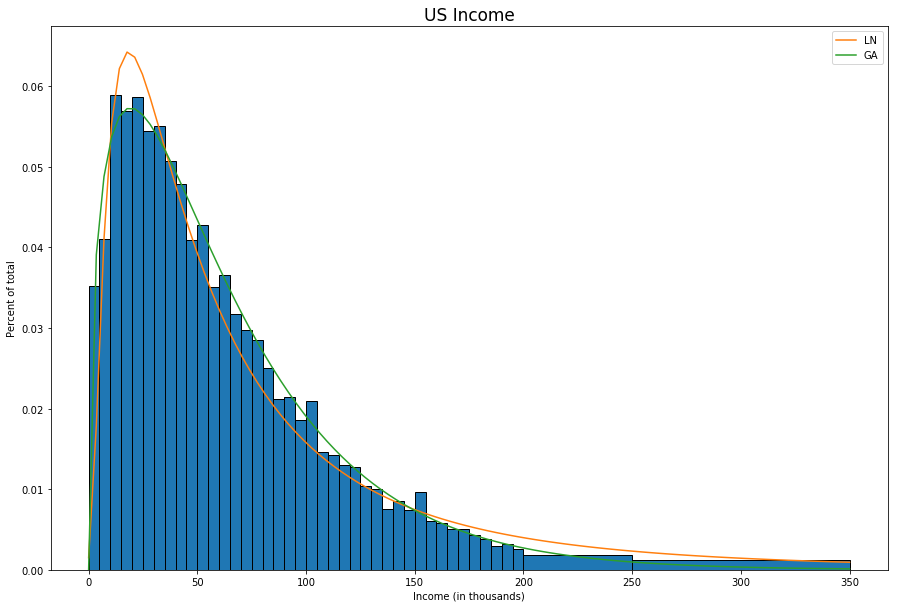

In [281]:
x = np.linspace(0.000001,350000,100)
yLN = model_moments(x, mu_GMM1, sig_GMM1)
yGA = model_momentsGA(x, alpha_GMM, beta_GMM)
plt.subplots(figsize=(15, 10))

plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')
plt.plot(x/1000,yLN, label = "LN")
plt.plot(x/1000,yGA, label = "GA")
plt.legend(loc = 'upper right')
plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

Instead of one method providing a better fit than the other, they both have strength and weakness. 
Formally, the LN method gets closer to the moments (as seen in the function value at the optimum). However, the difference is not significant, and GA 'looks' like a nice fit.
After contemplation, we have to note that LN does not fit 'quite right' for smaller (/ close to mode) values, while GA has its divergence at the larger values.

Thus, if we judge that the larger values are important (perhaps considering we have already discarded all values larger than 350000), we might prefer LN.
If we care less about large values, and more about the bulk of the distribution, we might think of using GA.

### (e)

We initialize the new W-matrix:

In [284]:
W = np.eye(42)

In [302]:
alpha_init = 3 #np.log(pcts @ midpts)
beta_init = 20000 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

      fun: 0.83104366609434799
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.66133815e-08,   9.99200722e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 171
      nit: 28
   status: 0
  success: True
        x: array([  1.38715578e+00,   4.59165017e+04])
alpha_GMM1= 1.38715577814  beta_GMM1= 45916.5016588


In [295]:
modelpcts = model_momentsGA(midpts, alpha_GMM1, beta_GMM1)
err_vec1 = (modelpcts - pcts)/pcts

In [299]:
Omega = np.outer(err_vec1.T, err_vec1)/42
W2 = np.linalg.pinv(Omega)

In [300]:
alpha_init = 3 #np.log(pcts @ midpts)
beta_init = 20000 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W2)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

      fun: 1.1505506602906278e-14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.00027402e-07,   9.39854418e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 6
   status: 0
  success: True
        x: array([  4.85678502e+00,   2.00000004e+04])
alpha_GMM1= 4.85678501518  beta_GMM1= 20000.0004069


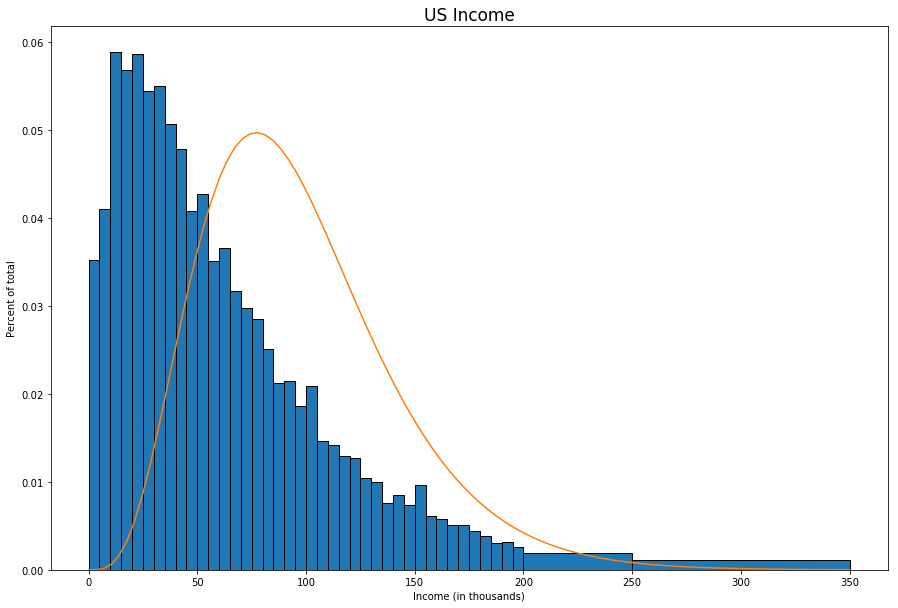

In [301]:
x = np.linspace(0.000001,350000,100)
y = model_momentsGA(x, alpha_GMM1, beta_GMM1)

plt.subplots(figsize=(15, 10))

plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')
plt.plot(x/1000,y)
plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

In [303]:
alpha_init = alpha_GMM1 #np.log(pcts @ midpts)
beta_init =  beta_GMM1 #np.sqrt(np.log(((smidpts - mu_init)**2)@ pcts)/mu_init)

params_init = np.array([alpha_init, beta_init])

gmm_args = (midpts, pcts, W2)
results = opt.minimize(critGA, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
print(results)
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

      fun: 7.3581830875575386e-15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.96355325e-08,  -6.66108351e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 5
   status: 0
  success: True
        x: array([  1.73040059e+00,   4.59165017e+04])
alpha_GMM1= 1.7304005907  beta_GMM1= 45916.5016708


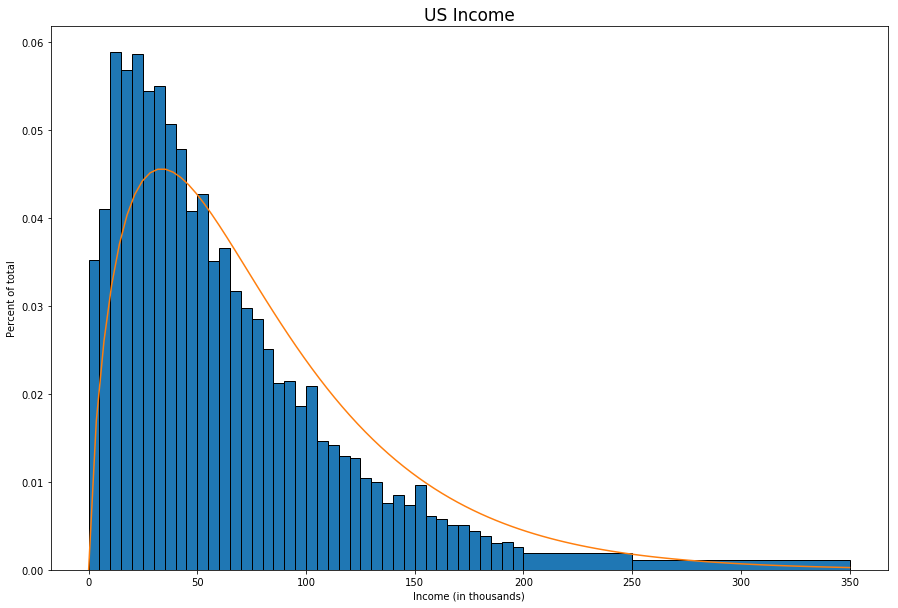

In [304]:
x = np.linspace(0.000001,350000,100)
y = model_momentsGA(x, alpha_GMM1, beta_GMM1)

plt.subplots(figsize=(15, 10))

plt.hist(smidpts, bins = bins, weights=pcts,edgecolor='k')
plt.plot(x/1000,y)
plt.title('US Income', fontsize=17)
plt.xlabel(r'Income (in thousands)')
plt.ylabel(r'Percent of total')
plt.show()

The numbers seem off to me, since the fit seems to be worse.